# Mislabel detection using influence function with all of layers on Cifar-10, ResNet

### Author
[Neosapience, Inc.](http://www.neosapience.com)

### Pre-train model conditions
---
- made mis-label from 1 percentage dog class to horse class
- augumentation: on
- iteration: 80000
- batch size: 128

#### cifar-10 train dataset
|           | horse |  dog | airplane | automobile | bird |  cat | deer | frog | ship | truck |
|----------:|:-----:|:----:|:--------:|:----------:|:----:|:----:|:----:|:----:|:----:|:-----:|
|   label   |  5000 | **4950** |   5000   |    5000    | 5000 | 5000 | 5000 | 5000 | 5000 |  5000 |
| mis-label |   **50**  |      |          |            |      |      |      |      |      |       |
|   total   |  **5050** | 4950 |   5000   |    5000    | 5000 | 5000 | 5000 | 5000 | 5000 |  5000 |


### License
---
Apache License 2.0

### References
---
- Darkon Documentation: <http://darkon.io>
- Darkon Github: <https://github.com/darkonhub/darkon>
- Resnet code: <https://github.com/wenxinxu/resnet-in-tensorflow>
- More examples: <https://github.com/darkonhub/darkon-examples>

### Index
- [Load results and analysis](#Load-results-and-analysis)
- [How to use upweight influence function for mis-label](#How-to-use-upweight-influence-function-for-mis-label)

## Load results and analysis

num tests: 5050
dogs in helpful: 6 / 100
mean for all: 2.45772849226e-06
mean for horse: 2.44922575777e-06
mean for dogs: 3.30800194102e-06
all of mis-labels: [ 951 2130 2761 3050 3084 3170 3198 3210 3231 3315 3449 3489 3547 3644 3676
 3765 3818 3876 3896 3912 4079 4276 4300 4320 4338 4372 4380 4429 4487 4519
 4572 4584 4695 4753 4754 4762 4802 4819 4828 4831 4876 4879 4881 4939 4955
 4978 5001 5011 5034 5048]


([<matplotlib.axis.XTick at 0x106108050>,
 <a list of 10 Text xticklabel objects>)

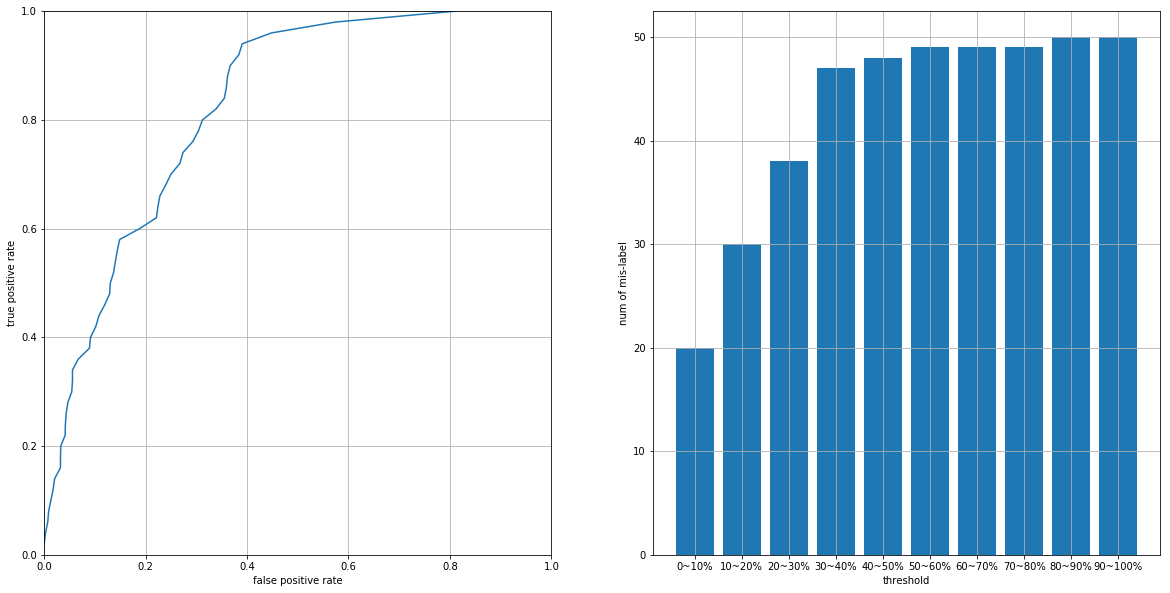

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

scores = np.load('mislabel-result-all.npy')
print('num tests: {}'.format(len(scores)))

begin_mislabel_idx = 5000
sorted_indices = np.argsort(scores)

print('dogs in helpful: {} / 100'.format(np.sum(sorted_indices[-100:] >= begin_mislabel_idx)))
print('mean for all: {}'.format(np.mean(scores)))
print('mean for horse: {}'.format(np.mean(scores[:begin_mislabel_idx])))
print('mean for dogs: {}'.format(np.mean(scores[begin_mislabel_idx:])))

mis_label_ranking = np.where(sorted_indices >= begin_mislabel_idx)[0]
print('all of mis-labels: {}'.format(mis_label_ranking))

total = scores.size
total_pos = mis_label_ranking.size
total_neg = total - total_pos

tpr = np.zeros([total_pos])
fpr = np.zeros([total_pos])
for idx in range(total_pos):
    tpr[idx] = float(total_pos - idx)
    fpr[idx] = float(total - mis_label_ranking[idx] - tpr[idx])

tpr /= total_pos
fpr /= total_neg

histogram = sorted_indices >= begin_mislabel_idx
histogram = histogram.reshape([10, -1])
histogram = np.sum(histogram, axis=1)
acc = np.cumsum(histogram[::-1])

fig, ax = plt.subplots(1, 2, figsize=(20, 10))
ax[0].set_ylabel('true positive rate')
ax[0].set_xlabel('false positive rate')
ax[0].set_ylim(0.0, 1.0)
ax[0].set_xlim(0.0, 1.0)
ax[0].grid(True)
ax[0].plot(fpr, tpr)

ax[1].set_ylabel('num of mis-label')
ax[1].set_xlabel('threshold')
ax[1].grid(True)
ax[1].bar(range(10), acc)

plt.sca(ax[1])
plt.xticks(range(10), ['{}~{}%'.format(p, p + 10) for p in range(0, 100, 10)])


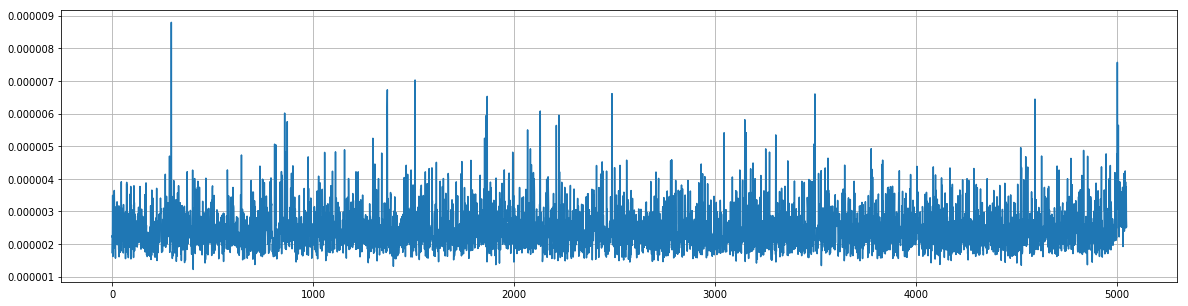

In [2]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.grid(True)
ax.plot(scores)

<br><br><br><br>

## How to use upweight influence function for mis-label 

### Import packages

In [2]:
# resnet: implemented by wenxinxu
from cifar10_input import *
from cifar10_train import Train

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import darkon

# to enable specific GPU
%set_env CUDA_VISIBLE_DEVICES=0

# cifar-10 classes
_classes = (
    'airplane',
    'automobile',
    'bird',
    'cat',
    'deer',
    'dog',
    'frog',
    'horse',
    'ship',
    'truck'
)

env: CUDA_VISIBLE_DEVICES=0


### Download/Extract cifar10 dataset

In [3]:
maybe_download_and_extract()

### Implement dataset feeder

In [4]:
class MyFeeder(darkon.InfluenceFeeder):
    def __init__(self):
        # load train data
        # for ihvp
        data, label = prepare_train_data(padding_size=0)
        # update some label
        label = self.make_mislabel(label)

        self.train_origin_data = data / 256.
        self.train_label = label
        self.train_data = whitening_image(data)
       
        self.train_batch_offset = 0

    def make_mislabel(self, label):
        target_class_idx = 7
        correct_indices = np.where(label == target_class_idx)[0]       
        self.correct_indices = correct_indices[:]
        
        # 1% dogs to horses.
        # In the mis-label model training, I used this script to choose random dogs.
        labeled_dogs = np.where(label == 5)[0]
        np.random.shuffle(labeled_dogs)
        mislabel_indices = labeled_dogs[:int(labeled_dogs.shape[0] * 0.01)]
        label[mislabel_indices] = 7.0
        self.mislabel_indices = mislabel_indices

        print('target class: {}'.format(_classes[target_class_idx]))
        print(self.mislabel_indices)
        return label

    def test_indices(self, indices):
        return self.train_data[indices], self.train_label[indices]

    def train_batch(self, batch_size):
        # for recursion part
        # calculate offset
        start = self.train_batch_offset
        end = start + batch_size
        self.train_batch_offset += batch_size

        return self.train_data[start:end, ...], self.train_label[start:end, ...]

    def train_one(self, idx):
        return self.train_data[idx, ...], self.train_label[idx, ...]

    def reset(self):
        self.train_batch_offset = 0

# to fix shuffled data
np.random.seed(75)
feeder = MyFeeder()

Reading images from cifar10_data/cifar-10-batches-py/data_batch_1
Reading images from cifar10_data/cifar-10-batches-py/data_batch_2
Reading images from cifar10_data/cifar-10-batches-py/data_batch_3
Reading images from cifar10_data/cifar-10-batches-py/data_batch_4
Reading images from cifar10_data/cifar-10-batches-py/data_batch_5
target class: horse
[21961 21986 27093 41046 11712 16494 24378 42274 24006 43962 35684 36899
 28777 37099 14932  6202 18096  5135 33765 44823  6358 42089 19335 11610
 10737 38555 43315 19835  9665 25727 13960 13911 42538 29577 42578   324
 42384 27401  1647 34188 17670 32919 45007 29459  4203 25826 22079 31240
 13067 17121]


### Restore pre-trained model

In [5]:
# tf model checkpoint
check_point = 'pre-trained-mislabel/model.ckpt-79999'

net = Train()
net.build_train_validation_graph()

saver = tf.train.Saver(tf.global_variables())
sess = tf.InteractiveSession()
saver.restore(sess, check_point)

INFO:tensorflow:Restoring parameters from pre-trained-mislabel/model.ckpt-79999


### Upweight influence options

In [15]:
approx_params = {
    'scale': 200,
    'num_repeats': 3,
    'recursion_depth': 50,
    'recursion_batch_size': 100
}

# targets
test_indices = list(feeder.correct_indices) + list(feeder.mislabel_indices)
print('num test targets: {}'.format(len(test_indices)))

num test targets: 5050


### Run upweight influence function

In [ ]:
# choose all of trainable layers
trainable_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)

# initialize Influence function
inspector = darkon.Influence(
    workspace='./influence-workspace',
    feeder=feeder,
    loss_op_train=net.full_loss,
    loss_op_test=net.loss_op,
    x_placeholder=net.image_placeholder,
    y_placeholder=net.label_placeholder,
    trainable_variables=trainable_variables)


scores = list()
for i, target in enumerate(test_indices):
    score = inspector.upweighting_influence(
        sess,
        [target],
        1,
        approx_params,
        [target],
        10000000,
        force_refresh=True
        )
    scores += list(score)
    print('done: [{}] - {}'.format(i, score))

print(scores)
np.save('mislabel-result-all.npy', scores)

### License

---
<pre>
Copyright 2017 Neosapience, Inc.

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.
</pre>

---